In [39]:
 #import packages for data analysis 
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt 
from collections import deque
from sklearn import preprocessing

In [40]:
#import the microsoft stock data
MSFT_d = pd.read_csv('MSFT_20100622-20200626.csv').add_suffix('_MSFT') 
MSFT_r = pd.read_csv('MSFT_ratings.csv')
MSF_de = pd.read_table('MSFde.txt', delimiter = ",").add_suffix('_MSFde') 

In [41]:
#remove nulls from MSF_de
MSF_de = MSF_de.iloc[0:2498,:]

In [42]:
#normalize data to proportional changes Adj Close and volume
MSFT_d['PctChange_MSFT'] = MSFT_d['Adj Close_MSFT'].pct_change()
MSFT_d['VolChange_MSFT'] = MSFT_d['Volume_MSFT'].pct_change()

MSFT_d.dropna(inplace=True)

MSF_de['PctChange_MSFde'] = MSF_de['Adj Close_MSFde'].pct_change()
MSF_de['VolChange_MSFde'] = MSF_de['Volume_MSFde'].pct_change()

MSF_de.dropna(inplace=True)

In [43]:
#scale the values 
MSFT_d['PctChange_MSFT'] = preprocessing.scale(MSFT_d['PctChange_MSFT'].values)
MSFT_d['VolChange_MSFT'] = preprocessing.scale(MSFT_d['VolChange_MSFT'].values)
MSFT_d.dropna(inplace=True)

In [44]:
#replacing inf in MSFde volchange
for i in list(range(1,(len(MSF_de.index)))):
    if MSF_de.VolChange_MSFde.iloc[i] == max(MSF_de.VolChange_MSFde):
        MSF_de.VolChange_MSFde.iloc[i] = 99

C:\Users\websterkgd\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
#scale MSF_De
MSF_de['PctChange_MSFde'] = preprocessing.scale(MSF_de['PctChange_MSFde'].values)
MSF_de['VolChange_MSFde'] = preprocessing.scale(MSF_de['VolChange_MSFde'].values)
MSF_de.dropna(inplace=True)

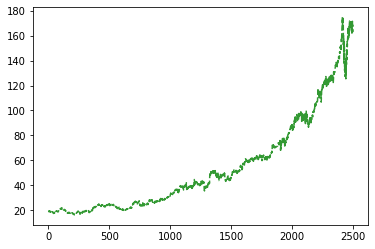

In [46]:
#quick plot
plt.plot(MSF_de.index, MSF_de['Open_MSFde'], 'b--', alpha = 0.8, color = 'green')
plt.show()

In [47]:
#handle opens, highs and lows  for MSFT
pc_open = [0]
pc_high = [0]
pc_low = [0]

for i in list(range(2,(len(MSFT_d.index)+1))):
    v = ((MSFT_d['Open_MSFT'][i]-MSFT_d['Close_MSFT'][i-1])/MSFT_d['Close_MSFT'][i-1])*100
    w = ((MSFT_d['High_MSFT'][i]-MSFT_d['Close_MSFT'][i-1])/MSFT_d['Close_MSFT'][i-1])*100
    x = ((MSFT_d['Low_MSFT'][i]-MSFT_d['Close_MSFT'][i-1])/MSFT_d['Close_MSFT'][i-1])*100
    pc_open.append(v)
    pc_high.append(w)
    pc_low.append(x)

MSFT_d['PccOpen_MSFT'] = pc_open
MSFT_d['PccHigh_MSFT'] = pc_high
MSFT_d['PccLow_MSFT'] = pc_low

In [48]:
#handle opens, highs and lows  for MSFde
pc_open =[0]
pc_high = [0]
pc_low = [0]

for i in list(range(1,(len(MSF_de.index)))):
    v = ((MSF_de.Open_MSFde.iloc[i]-MSF_de.Close_MSFde.iloc[i-1])/MSF_de.Close_MSFde.iloc[i-1])*100
    w = ((MSF_de.High_MSFde.iloc[i]-MSF_de.Close_MSFde.iloc[i-1])/MSF_de.Close_MSFde.iloc[i-1])*100
    x = ((MSF_de.Low_MSFde.iloc[i]-MSF_de.Close_MSFde.iloc[i-1])/MSF_de.Close_MSFde.iloc[i-1])*100
    pc_open.append(v)
    pc_high.append(w)
    pc_low.append(x)

MSF_de['PccOpen_MSFde'] = pc_open
MSF_de['PccHigh_MSFde'] = pc_high
MSF_de['PccLow_MSFde'] = pc_low

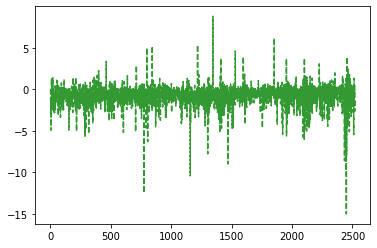

In [49]:
#quick plot
plt.plot(MSFT_d.index, MSFT_d['PccLow_MSFT'], 'b--', alpha = 0.8, color = 'green')
plt.show()

In [50]:
#choosing interval to predict and sequence length
seq_len = 60
fut_pred = 1

In [51]:
#create a future column
fut_class = []
for i in list(range(1,(len(MSFT_d.index)-fut_pred+1))):
    v = 0
    if MSFT_d['Adj Close_MSFT'][i+fut_pred] > MSFT_d['Adj Close_MSFT'][i]:
        v = 1
    else: v = 0
    fut_class.append(v)

In [52]:
#create a vector of NA for dates outside of the index
# add that list to the future class
fut_class = np.array(fut_class)
er = np.empty((1,fut_pred))
er[:] = np.nan
fut_class = np.append(fut_class, er)

In [53]:
#add the target column to the data frame
MSFT_d['target'] = fut_class
MSFT_d.dropna(inplace=True)

In [54]:
#pull out firm from firm_rating
Firm = []
for i in MSFT_r['Firm_Rating']:
    sep = ':'
    v = i.split(sep, 1)[0]
    Firm.append(v)
    
MSFT_r['Firm'] = Firm

In [55]:
#Rename Bank oferica to Bank of America
MSFT_r.Firm = MSFT_r.Firm.replace('Bank oferica', 'Bank of America')

In [56]:
#pull out rating from firm_rating
#change firm_rating 255 to Nuetral
MSFT_r['Firm_Rating'][255] = 'Nomura: to Neutral'
Rating = []
for i in MSFT_r['Firm_Rating']:
    sep = 'to '
    v = i.split(sep, 1)[1]
    Rating.append(v)
    
MSFT_r['Rating'] = Rating

In [57]:
#coding ratings, firms, up_down, into one hot encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [58]:
# integer encode firm
label_encoder = LabelEncoder()
firm_ie = label_encoder.fit_transform(MSFT_r.Firm) #integer encoding firm

In [59]:
#one hot encode firm
onehot_encoder = OneHotEncoder(sparse=False)
firm_ie = firm_ie.reshape(len(firm_ie), 1)
firm_oe = onehot_encoder.fit_transform(firm_ie)
firm_oe = pd.DataFrame(firm_oe, columns = label_encoder.classes_)

In [60]:
# integer encode Rating
label_encoder = LabelEncoder()
rating_ie = label_encoder.fit_transform(MSFT_r.Rating) 

In [61]:
#one hot encode Rating
onehot_encoder = OneHotEncoder(sparse=False)
rating_ie = rating_ie.reshape(len(rating_ie), 1)
rating_oe = onehot_encoder.fit_transform(rating_ie)
rating_oe = pd.DataFrame(rating_oe, columns = label_encoder.classes_)

In [62]:
# integer encode up_down
label_encoder = LabelEncoder()
up_down_ie = label_encoder.fit_transform(MSFT_r.Up_Down) 

In [63]:
#one hot encode up_down
onehot_encoder = OneHotEncoder(sparse=False)
up_down_ie = up_down_ie.reshape(len(up_down_ie), 1)
up_down_oe = onehot_encoder.fit_transform(up_down_ie)
up_down_oe = pd.DataFrame(up_down_oe, columns = label_encoder.classes_)

In [64]:
#add one hot encoders to MSFT_r
MSFT_woe = pd.concat([MSFT_r, firm_oe, rating_oe, up_down_oe], 
                     axis=1, join='outer')

In [65]:
#converting dates to datetime
MSFT_woe.Date = pd.to_datetime(MSFT_woe.Date)
MSFT_d.Date_MSFT = pd.to_datetime(MSFT_d.Date_MSFT)
MSF_de.Date_MSFde = pd.to_datetime(MSF_de.Date_MSFde)

In [66]:
#putting the data on the same timescales and indices
idx = pd.date_range(start = MSFT_woe.Date.iloc[-1], end = MSFT_d.Date_MSFT.iloc[-1])
MSFT_woe = MSFT_woe.reindex(idx, fill_value=0)

MSFT_d.index = MSFT_d.Date_MSFT
MSF_de.index = MSF_de.Date_MSFde

In [67]:
#joing the dataframes into predictive dataframe
MSFT_x = pd.concat([MSFT_woe, MSF_de, MSFT_d], axis=1, join='inner')

In [68]:
#MSFT_x.columns

Index(['Up_Down', 'Firm_Rating', 'Date', 'Firm', 'Rating', 'Argus',
       'Argus Research', 'Atlantic Equities', 'B. Riley FBR', 'BGC Financial',
       'BMO Capital', 'Bank of America', 'Barclays', 'CFRA',
       'Canaccord Genuity', 'Citi', 'Citigroup', 'Cowen & Co.',
       'Credit Agricole', 'Credit Suisse', 'Deutsche Bank',
       'Evercore Partners', 'FBN Securities', 'FBR Capital', 'Goldman Sachs',
       'Griffin Securities', 'Hilliard Lyons', 'JP Morgan', 'Jefferies',
       'KeyBanc', 'Longbow Research', 'MKM Partners', 'Macquarie',
       'McAdams Wright Ragen', 'Mizuho', 'Morgan Stanley', 'Nomura',
       'Oppenheimer', 'Pacific Crest', 'Piper Sandler', 'PiperJaffray',
       'RBC Capital', 'Raymond James', 'Standpoint Research', 'Sterne Agee',
       'Stifel', 'Stifel Nicolaus', 'Summit Research Partners',
       'SunTrust Robinson Humphrey', 'Tigress Financial', 'UBS', 'Wedbush',
       'Wells Fargo', 'William Blair', 'Wunderlich', 'Buy', 'Equal-Weight',
       'Hold', '

In [69]:
#drop columns that are problematic
MSFT_x = MSFT_x.drop(['Date', 'Date_MSFT', 'Up_Down', 'Firm', 'Rating',
                      'Firm_Rating', 'Open_MSFT', 'High_MSFT', 'Low_MSFT',
                      'Close_MSFT', 'Adj Close_MSFT', 'Volume_MSFT', 'Open_MSFde',
                      'High_MSFde', 'Close_MSFde', 'Volume_MSFde', 'Date_MSFde'], 
                     axis = 1) 

In [70]:
#building RNN

#importing packages
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, BatchNormalization 
#for output and layers 
from keras.models import Sequential # for RNN
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.python.keras.optimizers import TFOptimizer
from collections import deque
from keras.optimizers import Adam
import random
import time

In [71]:
 #cutting last 10 % of data to predict on
L_10 = MSFT_x[int(0.9*len(MSFT_x.index)):]

test_x = MSFT_x[:(int(0.9*len(MSFT_x.index))-1)]

In [72]:
#MSFT_x.columns

Index(['Argus', 'Argus Research', 'Atlantic Equities', 'B. Riley FBR',
       'BGC Financial', 'BMO Capital', 'Bank of America', 'Barclays', 'CFRA',
       'Canaccord Genuity', 'Citi', 'Citigroup', 'Cowen & Co.',
       'Credit Agricole', 'Credit Suisse', 'Deutsche Bank',
       'Evercore Partners', 'FBN Securities', 'FBR Capital', 'Goldman Sachs',
       'Griffin Securities', 'Hilliard Lyons', 'JP Morgan', 'Jefferies',
       'KeyBanc', 'Longbow Research', 'MKM Partners', 'Macquarie',
       'McAdams Wright Ragen', 'Mizuho', 'Morgan Stanley', 'Nomura',
       'Oppenheimer', 'Pacific Crest', 'Piper Sandler', 'PiperJaffray',
       'RBC Capital', 'Raymond James', 'Standpoint Research', 'Sterne Agee',
       'Stifel', 'Stifel Nicolaus', 'Summit Research Partners',
       'SunTrust Robinson Humphrey', 'Tigress Financial', 'UBS', 'Wedbush',
       'Wells Fargo', 'William Blair', 'Wunderlich', 'Buy', 'Equal-Weight',
       'Hold', 'Long-Term Buy', 'Market Perform', 'Neutral', 'Outperform',


In [73]:
#defining a function to get training and test data for RNN
def dataprep(df):
    sequential_data = []
    prev_days = deque(maxlen=seq_len)
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == seq_len:
            sequential_data.append([np.array(prev_days), i[-1]])
            
    random.shuffle(sequential_data)
    
    #balance the data
    buys = []
    sells = []
    
    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])
   
    random.shuffle(buys)
    random.shuffle(sells)
    
    lower = min(len(buys), len(sells))
    
    buys = buys[:lower]
    sells = sells[:lower]
    
    sequential_data = buys+sells
    
    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
    
    return np.array(X), y

In [74]:
#RNN info
Epochs = 10
Batch_size = 64
name = "{}-seq-{}-pred-{}".format(seq_len, fut_pred, int(time.time()))

In [75]:
#get dataframes
X_train, y_train = dataprep(test_x)
X_test, y_test = dataprep(L_10)

y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [89]:
# rnn model
model = Sequential()

model.add(LSTM(128, input_shape = X_train.shape[1:], activation = 'relu',
               return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape = X_train.shape[1:], activation = 'relu',
                    return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape = X_train.shape[1:], activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation ='softmax'))

opt = keras.optimizers.Adam(lr=1e-6)

#lr = keras.backend.variable(1e-6)

#tf_opt = tf.train.GradientDescentOptimizer(learning_rate=lr)

#opt = TFOptimizer(tf_opt)

#opt.lr = lr

model.compile(loss ='categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy']) 

tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

filepath =  "RNN_trial-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath,
                             monitor = "val_accuracy", verbose = 1))

history = model.fit(X_train, y_train_binary, batch_size = Batch_size, 
                    validation_data = (X_test, y_test_binary),  
                    callbacks = [tensorboard])
                    #callbacks = [tensorboard, checkpoint])

#model.save(filepath)

Train on 1648 samples, validate on 122 samples
Epoch 1/1
1648/1648 [==============================] - 38s 23ms/step - loss: 0.8820 - accuracy: 0.5061 - val_loss: 5.9445 - val_accuracy: 0.6066
